In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import os, sys


# Get the path two folders up
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
# Add the path to the sys.path
sys.path.append(path_to_add)

In [2]:
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../daeFinder/"))
sys.path.append(path_to_add)

from dae_finder import solveMM, plotToy_MM, plotToyEnz

#### Plotting solutions to different IC

## Lorrenz Chaotic System

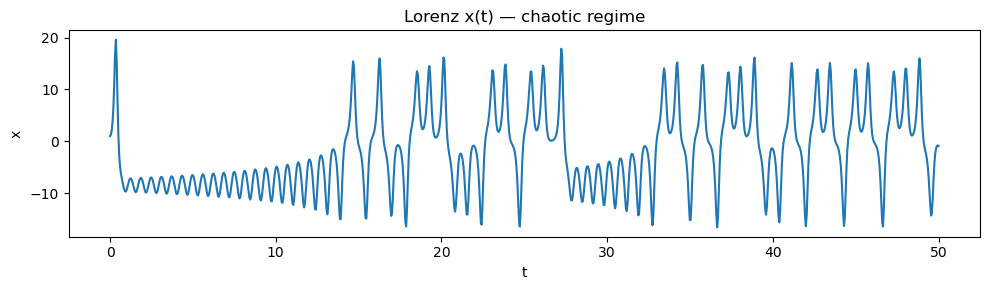

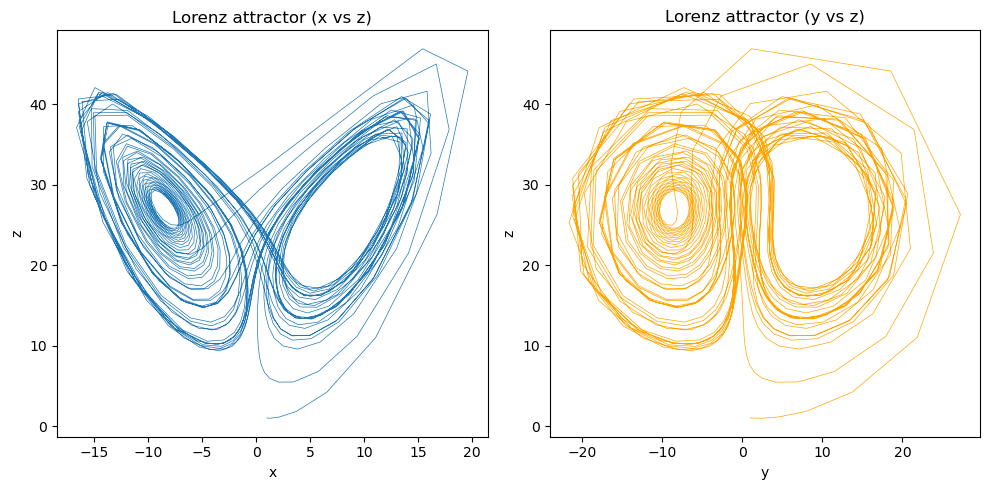

In [990]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

# simulation settings
final_time      = 50.0
num_time_points = 1000
t_span          = (0.0, final_time)
t_eval          = np.linspace(*t_span, num_time_points)

# classic Lorenz parameters (chaotic regime)
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

# one “small” perturbation from the origin
IC = [1.0, 1.0, 1.0]

# solve
sol = solve_ivp(
    fun=lorenz,
    t_span=t_span,
    y0=IC,
    t_eval=t_eval,
    args=(sigma, rho, beta),
    method='RK45',
)

# put results in a DataFrame if you like
data_matrix_df = pd.DataFrame(sol.y.T, columns=['x','y','z'])
data_matrix_df['t'] = sol.t
data_matrix_df_list = [data_matrix_df]

# --- now plot! ---

# 1) the x(t) time series
plt.figure(figsize=(10,3))
plt.plot(sol.t, sol.y[0])
plt.title('Lorenz x(t) — chaotic regime')
plt.xlabel('t')
plt.ylabel('x')
plt.tight_layout()
plt.show()

# 2) the phase‐space portrait x vs z
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left subplot: x vs z
axs[0].plot(sol.y[0], sol.y[2], linewidth=0.5)
axs[0].set_title('Lorenz attractor (x vs z)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')

# Right subplot: y vs z
axs[1].plot(sol.y[1], sol.y[2], linewidth=0.5, color='orange')
axs[1].set_title('Lorenz attractor (y vs z)')
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')

plt.tight_layout()
plt.show()

from copy import deepcopy

data_matrix_df_orig = deepcopy(data_matrix_df_list[0])


<Axes: >

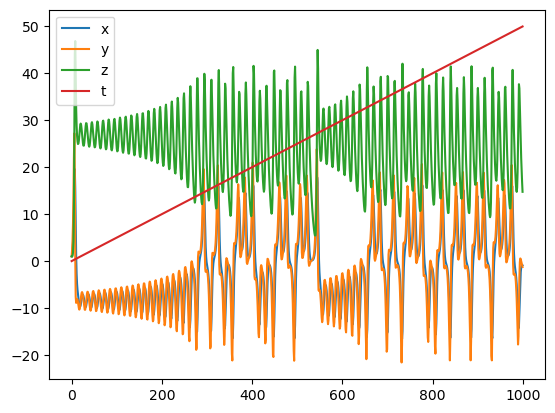

In [991]:
data_matrix_df.plot()

#### Adding noise

In [992]:
from dae_finder import add_noise_to_df
noise_perc = 0.01

data_matrix_df = deepcopy(data_matrix_df_orig)
for col in data_matrix_df.columns:
    if col != 't':
        data_matrix_df[col] += np.random.normal(0, noise_perc * data_matrix_df[col].std(), size=data_matrix_df[col].shape)


# data_matrix_features = data_matrix_df_list[0].columns
# for ind, data_matrix_ in enumerate(data_matrix_df_list):
#     # t_exact = data_matrix_["[t]"]
#     t_exact = data_matrix_["t"]
#     noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
#     noisy_data_df["t"] = t_exact
#     data_matrix_df_list[ind] = noisy_data_df

In [993]:
data_matrix_df

,x,y,z,t
0,0.93710594,0.95429524,0.83892938,0.00000000
1,1.42800389,2.33175643,0.94827356,0.05005005
2,2.21755694,4.48630357,1.11468292,0.10010010
3,3.73628615,7.93756270,1.97591516,0.15015015
4,6.47511934,13.74284894,4.23244725,0.20020020
...,...,...,...,...
995,-2.48606266,0.35833548,25.13063200,49.79979980
996,-1.28788434,-0.07863508,21.80077868,49.84984985
997,-0.95881047,-0.55444384,19.18817200,49.89989990
998,-0.82613300,-1.03015860,16.97883535,49.94994995


In [994]:
data_matrix_df_orig

,x,y,z,t
0,1.00000000,1.00000000,1.00000000,0.00000000
1,1.28792994,2.40203434,0.96390461,0.05005005
2,2.13550140,4.47650862,1.11494302,0.10010010
3,3.74340832,7.97750517,1.82082680,0.15015015
4,6.54874191,13.72930571,4.20830841,0.20020020
...,...,...,...,...
995,-2.34962200,0.38303800,25.07342655,49.79979980
996,-1.35869398,-0.02134945,21.92407992,49.84984985
997,-0.91740122,-0.41801949,19.19583819,49.89989990
998,-0.80300686,-0.80715631,16.82150431,49.94994995


# Defining Cadidate library (RHS of equations)

### Using polynomial features inspired from mass action kinetics

In [995]:
from dae_finder import PolyFeatureMatrix

poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df.drop("t", axis=1))


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,x,y,z,x^2,x y,x z,y^2,y z,z^2,x^3,x^2 y,x^2 z,x y^2,x y z,x z^2,y^3,y^2 z,y z^2,z^3
0,0.93710594,0.95429524,0.83892938,0.87816754,0.89427574,0.78616571,0.91067941,0.80058632,0.70380251,0.82293601,0.83803110,0.73672055,0.85340308,0.75023419,0.65953751,0.86905703,0.76399572,0.67163539,0.59044061
1,1.42800389,2.33175643,0.94827356,2.03919512,3.32975726,1.35413833,5.43708804,2.21114296,0.89922274,2.91197858,4.75490634,1.93371481,7.76418290,3.15752077,1.28409358,12.67796500,5.15584682,2.09676841,0.85270915
2,2.21755694,4.48630357,1.11468292,4.91755877,9.94863361,2.47187285,20.12691974,5.00080597,1.24251802,10.90496657,22.06166148,5.48151878,44.63259050,11.08957198,2.75535445,90.29547193,22.43513370,5.57431301,1.38501361
3,3.73628615,7.93756270,1.97591516,13.95983421,29.65700559,7.38258446,63.00490159,15.68395048,3.90424073,52.15793525,110.80705931,27.58344807,235.40434133,58.59972700,14.58736056,500.10535670,124.49234031,30.99015555,7.71444845
4,6.47511934,13.74284894,4.23244725,41.92717051,88.98658702,27.40560108,188.86589707,58.16588327,17.91360976,271.48343276,576.19877089,177.45453769,1222.92922337,376.63103588,115.99276105,2595.55549389,799.36494744,246.18403294,75.81840843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-2.48606266,0.35833548,25.13063200,6.18050753,-0.89084446,-62.47632572,0.12840432,9.00519715,631.54866488,-15.36512895,2.21469515,155.32006021,-0.31922118,-22.38748435,-1570.06955069,0.04601182,3.22688167,226.30629581,15871.21708935
996,-1.28788434,-0.07863508,21.80077868,1.65864607,0.10127289,-28.07688140,0.00618348,-1.71430593,475.27395102,-2.13614429,-0.13042776,36.15977579,-0.00796360,2.20782776,-612.09787740,-0.00048624,0.13480458,-37.37320425,10361.34221817
997,-0.95881047,-0.55444384,19.18817200,0.91931752,0.53160656,-18.39782023,0.30740797,-10.63876369,368.18594484,-0.88145126,-0.50970993,17.64002268,-0.29474598,10.20055802,-353.02053908,-0.17044045,5.89859695,-204.13842754,7064.81523880
998,-0.82613300,-1.03015860,16.97883535,0.68249574,0.85104802,-14.02677624,1.06122674,-17.49089324,288.28084992,-0.56383225,-0.70307885,11.58798278,-0.87671443,14.44980415,-238.15832425,-1.09323185,18.01839407,-296.97499641,4894.67308592


## Scaling the candidate library for numerical stability of optmizers.

- Some regularization methods like Lasso require the features to be on the same scale.
- We keep a version of the candidate library that is scaled to have std =1. 

In [996]:
#scaling the candidate columns to set std of 1
from sklearn.preprocessing import normalize
scaled_cand_lib = pd.DataFrame(normalize(candidate_lib_full, norm='l2', axis=0), columns=candidate_lib_full.columns)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

In [418]:
#scaling the candidate columns to set std of 1
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

In [997]:
scaled_cand_lib.describe()

,x,y,z,x^2,x y,x z,y^2,y z,z^2,x^3,x^2 y,x^2 z,x y^2,x y z,x z^2,y^3,y^2 z,y z^2,z^3
count,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000
mean,-0.00782839,-0.00700733,0.02997524,0.02192029,0.02024910,-0.00691543,0.01941072,-0.00721437,0.02686577,-0.00373331,-0.00350726,0.01966720,-0.00280269,0.01860204,-0.00555367,-0.00209268,0.01838763,-0.00646088,0.02365368
std,0.03065381,0.03085205,0.01007902,0.02280396,0.02430153,0.03087280,0.02497695,0.03080425,0.01668858,0.03141734,0.03144341,0.02477529,0.03151409,0.02558552,0.03114686,0.03156925,0.02574019,0.03097122,0.02099867
min,-0.06529458,-0.07568926,0.00104229,0.00000003,-0.01857056,-0.08628021,0.00000006,-0.09014140,0.00002919,-0.11731410,-0.12467455,0.00000001,-0.13415635,-0.02487120,-0.10430509,-0.13781323,0.00000007,-0.11139309,0.00000074
25%,-0.03181025,-0.02856975,0.02210451,0.00292989,0.00134562,-0.02614224,0.00169998,-0.02572719,0.01312692,-0.01356502,-0.01177227,0.00152763,-0.00959155,0.00093826,-0.02040829,-0.00741155,0.00137879,-0.02155333,0.00707517
50%,-0.01193283,-0.00920192,0.03000477,0.01485679,0.01183326,-0.00660981,0.00919345,-0.00687250,0.02418691,-0.00071610,-0.00045676,0.00987744,-0.00037038,0.00846845,-0.00323601,-0.00024764,0.00764465,-0.00421585,0.01769542
75%,0.01140524,0.00952782,0.03705158,0.03384060,0.03130858,0.00643352,0.02708947,0.00717598,0.03688185,0.00062523,0.00045208,0.02829184,0.00028576,0.02739648,0.00347991,0.00027490,0.02460975,0.00460404,0.03332029
max,0.07732914,0.09600589,0.05823806,0.13107889,0.14386379,0.11187472,0.17891111,0.11062802,0.09111987,0.19487155,0.18568835,0.17575568,0.23941640,0.17327078,0.14664240,0.28124301,0.17973946,0.16272894,0.12939257


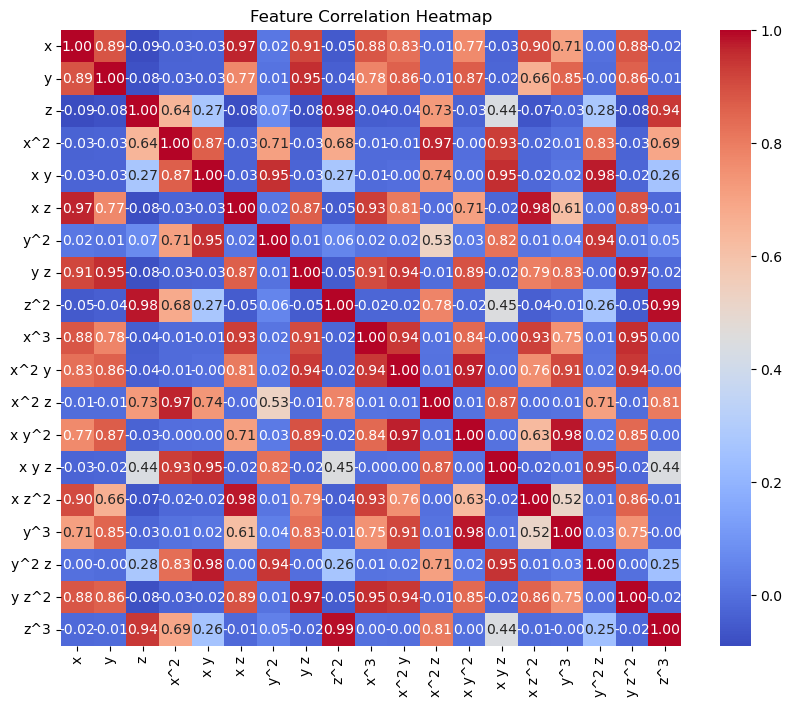

,Feature 1,Feature 2,Correlation
350,z^3,z^2,0.98738297
170,z^2,z^3,0.98738297
109,x z,x z^2,0.98199997
271,x z^2,x z,0.98199997
297,y^3,x y^2,0.98127225
243,x y^2,y^3,0.98127225
154,z^2,z,0.98059757
46,z,z^2,0.98059757
308,y^2 z,x y,0.97771211
92,x y,y^2 z,0.97771211


In [998]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = scaled_cand_lib.corr()

# Flatten the correlation matrix and sort by absolute correlation values
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlation_pairs = correlation_pairs[correlation_pairs['Feature 1'] != correlation_pairs['Feature 2']]
sorted_correlation_pairs = correlation_pairs.reindex(correlation_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Display sorted correlation pairs
sorted_correlation_pairs.head(10)

In [1000]:
from sklearn.linear_model import LinearRegression

# Compute the derivative of x using finite differences
dx_dt = np.gradient(candidate_lib_full['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
lin_model = LinearRegression()
lin_model.fit(candidate_lib_full, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
print(coefficients)
x = lin_model.coef_

{'x': np.float64(-13.012076558074972), 'y': np.float64(11.780038649893987), 'z': np.float64(-0.47374185559410686), 'x^2': np.float64(-0.03576637647201594), 'x y': np.float64(-0.01973444742070624), 'x z': np.float64(0.2091012388490813), 'y^2': np.float64(0.019281435444478016), 'y z': np.float64(-0.1100641222379637), 'z^2': np.float64(0.02748771043107955), 'x^3': np.float64(0.01868663015136368), 'x^2 y': np.float64(-0.026190948599141405), 'x^2 z': np.float64(0.0014571769263461265), 'x y^2': np.float64(0.01021330966267133), 'x y z': np.float64(0.0003012646878462924), 'x z^2': np.float64(-0.0041271613892455445), 'y^3': np.float64(-0.0019431469424537795), 'y^2 z': np.float64(-0.0004711428023117415), 'y z^2': np.float64(0.0021027433609744684), 'z^3': np.float64(-0.0004906168784641023)}


In [1001]:
from sklearn.linear_model import LinearRegression

# Compute the derivative of x using finite differences
dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
lin_model = LinearRegression()
lin_model.fit(scaled_cand_lib, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
print(coefficients)
x = lin_model.coef_

{'x': np.float64(-13.012076558065099), 'y': np.float64(13.180589480071312), 'z': np.float64(-1.4988430061729001), 'x^2': np.float64(-0.4151002446178486), 'x y': np.float64(-0.24788444200890022), 'x z': np.float64(6.383480221311706), 'y^2': np.float64(0.3163723170271101), 'y z': np.float64(-3.207455577348556), 'z^2': np.float64(2.6055081575922157), 'x^3': np.float64(2.869861730859332), 'x^2 y': np.float64(-4.287776592641508), 'x^2 z': np.float64(0.5570618254273905), 'x y^2': np.float64(2.1066812523938925), 'x y z': np.float64(0.1102733358256184), 'x z^2': np.float64(-4.24535944859754), 'y^3': np.float64(-0.5542819760866071), 'y^2 z': np.float64(-0.20310807627811445), 'y z^2': np.float64(1.839887030020843), 'z^3': np.float64(-1.5351321675164735)}


In [18]:
from sklearn.linear_model import LinearRegression

# Compute the derivative of x using finite differences
dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
lin_model = LinearRegression()
lin_model.fit(scaled_cand_lib, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
print(coefficients)
x = lin_model.coef_

{'x': np.float64(-12.407505325982223), 'y': np.float64(12.75894491325573), 'z': np.float64(-0.8058249109110874), 'x^2': np.float64(-0.16074457227024427), 'x y': np.float64(0.014992235139227282), 'x z': np.float64(1.7147262875773528), 'y^2': np.float64(0.051377010598956115), 'y z': np.float64(-0.7638080253606171), 'z^2': np.float64(1.3314873873828683), 'x^3': np.float64(-0.68458395648413), 'x^2 y': np.float64(-0.26149307824704354), 'x^2 z': np.float64(0.28328321085603403), 'x y^2': np.float64(0.29668802268262884), 'x y z': np.float64(-0.11489266971122528), 'x z^2': np.float64(1.104135378277018), 'y^3': np.float64(-0.2359739229006739), 'y^2 z': np.float64(-0.01261871254481934), 'y z^2': np.float64(-0.2238050524945891), 'z^3': np.float64(-0.7763116362094896)}


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Compute the derivative of x using finite differences
dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
# Fit the derivative series against the scaled candidate library using Ridge regression
ridge_model = Ridge(alpha=0.3)
ridge_model.fit(scaled_cand_lib, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(scaled_cand_lib.columns, ridge_model.coef_))

print(coefficients)
x = ridge_model.coef_

{'x': np.float64(-0.6606498536900279), 'y': np.float64(2.05768030136304), 'z': np.float64(0.01009738974140629), 'x^2': np.float64(0.027398265864617584), 'x y': np.float64(0.014827235356069973), 'x z': np.float64(-1.5473497305966308), 'y^2': np.float64(-0.059563116579254935), 'y z': np.float64(1.1243074266044422), 'z^2': np.float64(0.021086616356931587), 'x^3': np.float64(-0.6248223465815749), 'x^2 y': np.float64(0.3098343321535426), 'x^2 z': np.float64(0.017681087488713693), 'x y^2': np.float64(0.603602840247798), 'x y z': np.float64(0.020477010711590967), 'x z^2': np.float64(-1.931484132988741), 'y^3': np.float64(0.9218615214509207), 'y^2 z': np.float64(-0.0830939037205056), 'y z^2': np.float64(0.4886268626160604), 'z^3': np.float64(0.010291863836301927)}


## Testing illconditioning of the STOLS problem

In [136]:
# Defining STOLS

def stols(coefficients, pd_dict = True, threshold=0.1):
    """
    Selects features based on a threshold applied to the absolute values of coefficients.
    
    Parameters:
    coefficients (dict): Dictionary of feature names and their corresponding coefficients.
    threshold (float): Threshold value for selecting features.
    
    Returns:
    list: List of selected feature names.
    """
    selected_features = {feature: coef for feature, coef in coefficients.items() if abs(coef) > threshold}
    if pd_dict:
        return pd.DataFrame.from_dict(selected_features, orient='index', columns=['Coefficient']) 
    else:
        return selected_features

In [137]:
stols_df = stols(coefficients, pd_dict=True, threshold=0.1)

In [138]:
## Using scaled_cand_lib

In [139]:
stols_df

,Coefficient
x,-0.66064985
y,2.05768030
x z,-1.54734973
y z,1.12430743
x^3,-0.62482235
x^2 y,0.30983433
x y^2,0.60360284
x z^2,-1.93148413
y^3,0.92186152
y z^2,0.48862686


## Scaled candidate library (Term size based thresholding):

In [457]:
A = scaled_cand_lib.to_numpy()
a = np.ones((A.shape[0], 1))
A_design = np.hstack((a, A))

U, S, Vt = np.linalg.svd(A_design, full_matrices=True)
S

array([3.16994484e+01, 2.88923678e+00, 1.84232612e+00, 9.77836368e-01,
       9.40678934e-01, 5.23468001e-01, 3.84963040e-01, 2.61331307e-01,
       1.87322343e-01, 1.28913992e-01, 9.72516955e-02, 7.98015239e-02,
       4.21476579e-02, 3.19921193e-02, 2.75438176e-02, 1.86993988e-02,
       8.15826323e-03, 5.81468807e-03, 3.45858710e-03, 2.83646585e-03])

In [458]:
np.linalg.norm(A_design.T @ U[:,0])/np.linalg.norm(A_design.T @ U[:,A_design.shape[1]-1]) 


np.float64(11175.68486465211)

In [459]:
np.linalg.norm(A.T @ U[:,0])/np.linalg.norm(A.T @ U[:,A_design.shape[1]-1]) 

np.float64(777.9783918676133)

noise_magnitude: 7.155049410606718
noise_percentage: 1.5038643625152497
x_true: [-1.24075053e+01  1.27589449e+01 -8.05824911e-01 -1.60744572e-01
  1.49922351e-02  1.71472629e+00  5.13770106e-02 -7.63808025e-01
  1.33148739e+00 -6.84583956e-01 -2.61493078e-01  2.83283211e-01
  2.96688023e-01 -1.14892670e-01  1.10413538e+00 -2.35973923e-01
 -1.26187125e-02 -2.23805052e-01 -7.76311636e-01]
x_model: [ -4.59069969   9.96352706  -0.9957814  -27.5451584   61.04402934
  -0.07629603 -31.63793155 -10.07007214 -25.16296767   7.72241276
 -23.83196444   6.68314542  20.03588304 -34.51350014  -5.72435555
  -4.45547723  19.27593626  12.57263068  31.15092627]
x_model-x_true [  7.81680563  -2.79541785  -0.18995649 -27.38441383  61.02903711
  -1.79102232 -31.68930856  -9.30626411 -26.49445505   8.40699672
 -23.57047136   6.39986221  19.73919502 -34.39860747  -6.82849093
  -4.2195033   19.28855497  12.79643573  31.92723791]
relative norm(x - lin_model.coef_)/norm(x): 5.598860841735527


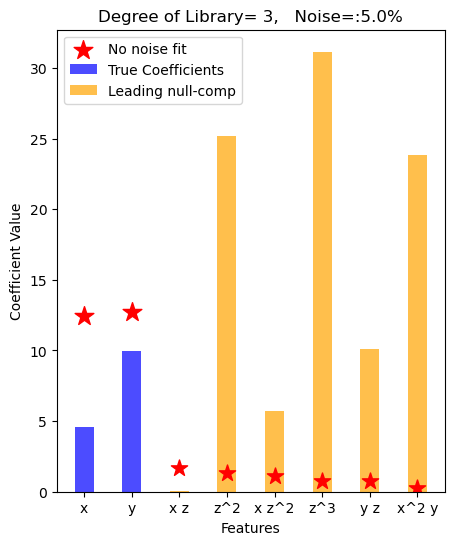

In [962]:

# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
# A = scaled_cand_lib.to_numpy()


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
#Calculating the derivative of x using finite differences
# np.random.seed(101)
dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
y = dx_dt_series.to_numpy()

# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
ill_noise_perc = 0.00
other_noise_perc = 0.05

y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
# y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
# from sklearn.linear_model import Ridge
lin_model_true = LinearRegression(fit_intercept=True)
lin_model_true.fit(A, y)
# lin_model = LinearRegression()
lin_model_true.fit(scaled_cand_lib, dx_dt_series)
x = lin_model_true.coef_


lin_model = LinearRegression(fit_intercept=True)
# lin_model = Ridge(alpha=1, fit_intercept=True)
lin_model.fit(scaled_cand_lib, y_noisy)
x_model = lin_model.coef_

print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

print("x_true:", x)
print("x_model:", x_model)
print("x_model-x_true", x_model-(x))
print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))

# Create a tuple containing the index and value of each component of Vt[-1, :]
x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
sorted_x_model_last = sorted_x_model_last[::-1]
sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])


# Create a tuple containing the index and value of each component of Vt[-1, :]
x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
sorted_x_true_last = sorted_x_true_last[::-1]
sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])



# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]

# Sort the tuple based on the magnitude of the value
sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
sorted_vt_last_component = sorted_vt_last_component[::-1]
sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])






import matplotlib.pyplot as plt

true_model_coef = ["x", "y"]
true_model_df = sorted_vt_last_component_df.loc[true_model_coef]

# Extract the first four indices of vt_last_component
vt_dom_components = sorted_vt_last_component_df.index[:6]

# Create a bar plot
fig, ax = plt.subplots(figsize=(5, 6))  # Reduce the width of the plot

# Plot the first two indices of sorted_x_model_df with smaller bar thickness
ax.bar(true_model_coef, abs(sorted_x_model_df.loc[true_model_coef]['Coefficient']), label='True Coefficients', color='blue', alpha=0.7, width=0.4)

# Plot the first four indices of vt_last_component with smaller bar thickness
ax.bar(vt_dom_components, abs(sorted_x_model_df.loc[vt_dom_components]['Coefficient']), label='Leading null-comp', color='orange', alpha=0.7, width=0.4)

# Add scatter plots for the true model coefficients
ax.scatter(true_model_coef, abs(sorted_x_true_df.loc[true_model_coef]['Coefficient']), label='No noise fit', color='red', marker='*', s=200)
ax.scatter(vt_dom_components, abs(sorted_x_true_df.loc[vt_dom_components]['Coefficient']), color='red', marker='*', s=150)

# Add labels and title
ax.set_ylabel('Coefficient Value')
ax.set_xlabel('Features')

ax.set_title('Degree of Library= {},   Noise=:{}'.format(poly_degree, other_noise_perc*100) + '%')
ax.legend()

plt.show()
file_name = "OLS_degree_{}_noise_{}.png".format(poly_degree, other_noise_perc*100)
# fig.savefig(os.path.join("figures", file_name), dpi=300)


## Making animation for different noise realizations

In [ ]:
import os


# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
# A = scaled_cand_lib.to_numpy()


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
#Calculating the derivative of x using finite differences
frame_files = []
for ind in range(10):

    np.random.seed(ind)
    dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)
    dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
    y = dx_dt_series.to_numpy()

    # y_noise_comp = A @ noise_comp
    # y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
    ill_noise_perc = 0.00
    other_noise_perc = 0.05

    y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
    # y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

    y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
    # from sklearn.linear_model import Ridge
    lin_model_true = LinearRegression(fit_intercept=True)
    lin_model_true.fit(A, y)
    # lin_model = LinearRegression()
    lin_model_true.fit(scaled_cand_lib, dx_dt_series)
    x = lin_model_true.coef_


    lin_model = LinearRegression(fit_intercept=True)
    # lin_model = Ridge(alpha=1, fit_intercept=True)
    lin_model.fit(scaled_cand_lib, y_noisy)
    x_model = lin_model.coef_

    # print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
    # print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

    # print("x_true:", x)
    # print("x_model:", x_model)
    # print("x_model-x_true", x_model-(x))
    # print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))

    # Create a tuple containing the index and value of each component of Vt[-1, :]
    x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

    # Sort the tuple based on the magnitude of the value
    sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
    sorted_x_model_last = sorted_x_model_last[::-1]
    sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
    sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])


    # Create a tuple containing the index and value of each component of Vt[-1, :]
    x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

    # Sort the tuple based on the magnitude of the value
    sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
    sorted_x_true_last = sorted_x_true_last[::-1]
    sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
    sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])



    # Create a tuple containing the index and value of each component of Vt[-1, :]
    vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]

    # Sort the tuple based on the magnitude of the value
    sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
    sorted_vt_last_component = sorted_vt_last_component[::-1]
    sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
    sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])






    import matplotlib.pyplot as plt

    true_model_coef = ["x", "y"]
    true_model_df = sorted_vt_last_component_df.loc[true_model_coef]

    # Extract the first four indices of vt_last_component
    vt_dom_components = sorted_vt_last_component_df.index[:6]

    # Create a bar plot
    fig, ax = plt.subplots(figsize=(5, 6))  # Reduce the width of the plot

    # Plot the first two indices of sorted_x_model_df with smaller bar thickness
    ax.bar(true_model_coef, abs(sorted_x_model_df.loc[true_model_coef]['Coefficient']), label='True Coefficients', color='blue', alpha=0.7, width=0.4)

    # Plot the first four indices of vt_last_component with smaller bar thickness
    ax.bar(vt_dom_components, abs(sorted_x_model_df.loc[vt_dom_components]['Coefficient']), label='Leading null-comp', color='orange', alpha=0.7, width=0.4)

    # Add scatter plots for the true model coefficients
    ax.scatter(true_model_coef, abs(sorted_x_true_df.loc[true_model_coef]['Coefficient']), label='No noise fit', color='red', marker='*', s=200)
    ax.scatter(vt_dom_components, abs(sorted_x_true_df.loc[vt_dom_components]['Coefficient']), color='red', marker='*', s=150)

    # Add labels and title
    ax.set_ylabel('Coefficient Value')
    ax.set_xlabel('Features')

    ax.set_title('Degree of Library= {},   Noise=:{}'.format(poly_degree, other_noise_perc*100) + '%')
    ax.legend()

    # plt.show()
    file_name = "OLS_degree_{}_noise_{}.png".format(poly_degree, other_noise_perc*100)

    import matplotlib.animation as animation

    # Create a directory to save the frames if it doesn't exist
    frames_dir = "frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Save each frame as an image
    frame_file = os.path.join(frames_dir, f"frame_{ind:03d}.png")
    frame_files.append(frame_file)
    fig.savefig(frame_file, dpi=300)
    plt.close(fig)



file_name = "figures/OLS_degree_{}_noise_{}.mp4".format(poly_degree, other_noise_perc*100)





image_files = frame_files  # List of image files to create a video from
import cv2

# Read the first image to get frame size
frame = cv2.imread(image_files[0])
height, width, layers = frame.shape
size = (width, height)

# Define the codec and create VideoWriter object
out = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, size)

for filename in image_files:
    img = cv2.imread(filename)
    out.write(img)

out.release()
print("Video created successfully!")


Video created successfully!


In [512]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
sorted_x_model_last = sorted_x_model_last[::-1]
sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])

sorted_x_model_df

,Coefficient
x z,-93.22771568
z^2,83.69406324
x z^2,78.31940317
x^2 y,70.58497457
y z,63.96051779
z^3,-54.51457123
x y^2,-50.06873386
y z^2,-49.47207219
x^2 z,42.81509611
z,-40.07926674


In [513]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
sorted_x_true_last = sorted_x_true_last[::-1]
sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])

sorted_x_true_df

,Coefficient
y,12.75894491
x,-12.40750533
x z,1.71472629
z^2,1.33148739
x z^2,1.10413538
z,-0.80582491
z^3,-0.77631164
y z,-0.76380803
x^3,-0.68458396
x y^2,0.29668802


In [514]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]

# Sort the tuple based on the magnitude of the value
sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
sorted_vt_last_component = sorted_vt_last_component[::-1]
sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])


sorted_vt_last_component_df  # Display in descending order of magnitude

,Coefficient
x z,0.45686348
z^2,-0.41245947
x z^2,-0.39272060
z^3,0.30335435
y z,-0.29086028
x^2 y,-0.27366668
y z^2,0.20970943
x^3,0.19465124
z,0.18672244
x y^2,0.15018497


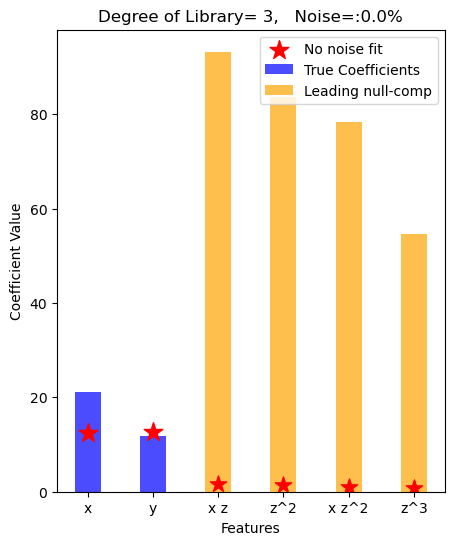

## Unscaled candidate library (Coefficient size based thresholding):

In [36]:
A = candidate_lib_full.to_numpy()

a = np.ones((A.shape[0], 1))
A_design = np.hstack((a, A))

U, S, Vt = np.linalg.svd(A_design, full_matrices=True)
S

array([8.08439694e+05, 3.37133225e+05, 1.17771177e+05, 1.01409515e+05,
       4.54359616e+04, 2.56728641e+04, 9.22118359e+03, 7.38454746e+03,
       3.22150780e+03, 1.85656863e+03, 9.61875844e+02, 7.48628844e+02,
       6.02282721e+02, 1.65440462e+02, 8.75836658e+01, 2.91495595e+01,
       2.30880146e+01, 1.46017892e+01, 2.75897942e+00, 1.68196457e+00])

In [37]:
np.linalg.norm(A_design.T @ U[:,0])/np.linalg.norm(A_design.T @ U[:,A_design.shape[1]-1]) 


np.float64(480652.0351582761)

In [38]:
np.linalg.norm(A.T @ U[:,0])/np.linalg.norm(A.T @ U[:,A_design.shape[1]-1]) 

np.float64(2120153.2870151103)

In [43]:

# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
# A = scaled_cand_lib.to_numpy()


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
#Calculating the derivative of x using finite differences
dx_dt = np.gradient(candidate_lib_full['x'], t_exact)
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
y = dx_dt_series.to_numpy()

# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
ill_noise_perc = 0.1
other_noise_perc = 0.0

y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
# y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
# from sklearn.linear_model import Ridge
lin_model_true = LinearRegression(fit_intercept=True)
lin_model_true.fit(A, y)
# lin_model = LinearRegression()
lin_model_true.fit(candidate_lib_full, dx_dt_series)
x = lin_model_true.coef_


lin_model = LinearRegression(fit_intercept=True)
# lin_model = Ridge(alpha=1, fit_intercept=True)
lin_model.fit(candidate_lib_full, y_noisy)
x_model = lin_model.coef_

print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

print("x_true:", x)
print("x_model:", x_model)
print("x_model-x_true", x_model-(x))
print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))


noise_magnitude: 120.98195912157898
noise_percentage: 0.09999999999999999
x_true: [-1.24075053e+01  1.14033949e+01 -2.54535435e-01 -1.38572592e-02
  1.19426729e-03  5.61597045e-02  3.13419000e-03 -2.62043048e-02
  1.40361470e-02 -4.46361492e-03 -1.59970895e-03  7.41344130e-04
  1.44096804e-03 -3.14016104e-04  1.07313752e-03 -8.28996860e-04
 -2.92907233e-05 -2.55695732e-04 -2.47875066e-04]
x_model: [-6.00059120e+00  4.86851166e+00 -1.36409308e+01 -8.25736961e-01
 -4.10955043e-01 -7.44978390e-01  4.58791030e-01  7.39012802e-01
  8.27784204e-01 -8.50224496e-02  1.35126812e-01  5.62812750e-02
 -6.96638273e-02 -1.78315742e-02  2.31673538e-02  9.65796837e-03
 -5.42210297e-03 -2.05011198e-02 -1.60095480e-02]
x_model-x_true [ 6.40691412e+00 -6.53488321e+00 -1.33863954e+01 -8.11879702e-01
 -4.12149310e-01 -8.01138094e-01  4.55656840e-01  7.65217107e-01
  8.13748057e-01 -8.05588347e-02  1.36726521e-01  5.55399308e-02
 -7.11047953e-02 -1.75175581e-02  2.20942163e-02  1.04869652e-02
 -5.39281224e-

In [44]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
sorted_x_model_last = sorted_x_model_last[::-1]
sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])

sorted_x_model_df

,Coefficient
z,-13.64093079
x,-6.00059120
y,4.86851166
z^2,0.82778420
x^2,-0.82573696
x z,-0.74497839
y z,0.73901280
y^2,0.45879103
x y,-0.41095504
x^2 y,0.13512681


In [45]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
sorted_x_true_last = sorted_x_true_last[::-1]
sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])

sorted_x_true_df

,Coefficient
x,-12.40750533
y,11.40339487
z,-0.25453543
x z,0.05615970
y z,-0.02620430
z^2,0.01403615
x^2,-0.01385726
x^3,-0.00446361
y^2,0.00313419
x^2 y,-0.00159971


In [46]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]

# Sort the tuple based on the magnitude of the value
sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
sorted_vt_last_component = sorted_vt_last_component[::-1]
sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])


sorted_vt_last_component_df  # Display in descending order of magnitude

,Coefficient
z,-0.18610579
y,-0.09085191
x,0.08907281
z^2,0.01131322
x^2,-0.01128724
x z,-0.01113791
y z,0.01063851
y^2,0.00633482
x y,-0.00572995
x^2 y,0.00190086


In [ ]:
np.linalg.norm(A @ Vt[-1, :])

np.float64(0.14751820171521365)

## Finding highly correlated terms in the candidate library

In [15]:
from sklearn.linear_model import LinearRegression

# Extract the features z^3 and z^2 from the scaled candidate library
z_cubed = scaled_cand_lib['z^2']
z_squared = scaled_cand_lib['z^3']

# Perform linear regression
lin_model = LinearRegression()
lin_model.fit(z_squared.values.reshape(-1, 1), z_cubed)

# Get the coefficient
coefficient_corr = lin_model.coef_[0]
coefficient_corr

np.float64(0.9873734159695747)

In [16]:
lin_model.intercept_
intercept_corr = lin_model.intercept_
lin_model.score(z_squared.values.reshape(-1, 1), z_cubed)

0.9749062625634284

In [17]:
corr_dir_1 = scaled_cand_lib.columns.get_loc('z^2')
corr_dir_2 = scaled_cand_lib.columns.get_loc('z^3')

In [18]:
noise_perc = 0.01
U, S, Vt = np.linalg.svd(A, full_matrices=True)
# y_noise_comp = U[:,5-1] * noise_perc
# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
corr_dir = np.zeros(A.shape[1])
corr_dir[corr_dir_1] = 1
corr_dir[corr_dir_2] = -coefficient_corr

np.linalg.norm(A @ corr_dir )

NameError: name 'A' is not defined

In [757]:
S

array([1.72872323e+02, 1.17242134e+02, 7.67606302e+01, 4.23145959e+01,
       3.86256634e+01, 2.31880216e+01, 1.80738262e+01, 1.56347155e+01,
       1.44228678e+01, 7.25582140e+00, 6.46438543e+00, 5.13546258e+00,
       3.94933721e+00, 3.20860805e+00, 2.63811011e+00, 1.83792031e+00,
       1.52617289e+00, 9.67850395e-01, 8.72275185e-01, 7.13823812e-01,
       4.97756843e-01, 4.14565752e-01, 3.18742286e-01, 2.12528630e-01,
       1.66887441e-01, 1.42332068e-01, 9.21460855e-02, 6.37511572e-02,
       4.60391032e-02, 2.47718677e-02, 2.28707400e-02, 1.80354082e-02,
       1.41773548e-02, 8.90262114e-03])

In [758]:
np.std(A @ corr_dir)

np.float64(0.15836378988512995)

In [771]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
A = scaled_cand_lib.to_numpy()
A_appended = np.hstack((A, np.ones((A.shape[0], 1))))
lin_model.fit(A_appended, dx_dt_series)
print("x_model:", lin_model.coef_)
x = lin_model.coef_

x_model: [-1.24075053e+01  1.28409340e+01 -2.64895928e-01 -1.19569459e-01
  1.18820066e-02  1.72689512e+00  4.18480902e-02 -7.67521850e-01
  7.24780894e-01 -7.01572249e-01 -2.68209798e-01  2.28919286e-01
  3.04993229e-01 -9.58655736e-02  1.12181249e+00 -2.43002339e-01
 -1.05928647e-02 -2.26109358e-01 -5.31747437e-01  0.00000000e+00]


In [776]:
corr_dir = np.zeros(A_appended.shape[1])
corr_dir[corr_dir_1] = 1
corr_dir[corr_dir_2] = -coefficient_corr
corr_dir[-1] = -intercept_corr

np.linalg.norm(A_appended @ corr_dir )

np.float64(5.007902749333455)

In [763]:
np.linalg.norm(A.T @  U[:,A.shape[1]-1])

np.float64(0.10140039391239017)

In [844]:

# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
A = scaled_cand_lib.to_numpy()
U, S, Vt = np.linalg.svd(A, full_matrices=True)


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
y = dx_dt_series.to_numpy()
# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
noise_perc = 0
y_noise_comp = U[:,A.shape[1]-1] * np.std(y)*noise_perc
y_noisy = y + y_noise_comp
from sklearn.linear_model import LinearRegression
# lin_model = LinearRegression(fit_intercept=True)
lin_model = Ridge(alpha=0.1, fit_intercept=True)

lin_model.fit(A, y_noisy)
print("noise_magnitude:", np.linalg.norm(y_noise_comp))
print("x_true:", x)
print("x_model:", lin_model.coef_)
print("x_model-x_true", lin_model.coef_-(x))
print("norm(x - lin_model.coef_):", np.linalg.norm(x - lin_model.coef_))


noise_magnitude: 0.0
x_true: [-7.54403353e+00  1.00586852e+01 -2.06337676e-01  1.23483296e-01
  1.88482583e-02 -4.53363226e+00 -5.66686528e-02  1.86485696e+00
  4.32121935e-01  5.38669355e-01 -6.91608591e-01 -3.60958262e-02
 -6.58876375e-02 -1.26669828e-01 -1.49023134e-01  1.33275537e-01
  5.32882735e-02  3.36188266e-03 -4.07556630e-02 -9.52656500e-02
 -1.93793444e-01 -7.48247174e-02 -2.36630460e-01 -5.80632651e-02
  2.42137882e-02  8.07549980e-02  1.25977977e-01 -6.18651859e-02
  1.88810297e+00  1.10475521e-01 -3.04706804e-01  1.42025068e-01
 -2.06730170e-01 -2.01197431e-01 -1.16652740e+00  7.29716463e-01
  1.35093679e-01  2.16505958e-01  1.26957302e-01 -1.26921047e+00
 -2.44715659e-02 -1.08582137e-01  4.00136625e-01  7.51930082e-02
 -6.67255983e-02  1.66767633e-01  3.94920216e-01  6.81514956e-02
  1.63973190e+00 -4.08967672e-02 -5.70233007e-02 -1.96168544e-01
 -3.76948090e-02 -2.27349039e-01 -1.10516174e-01]
x_model: [-7.54403353e+00  1.00586852e+01 -2.06337676e-01  1.23483296e-01
  

In [90]:
S

array([2.09701983e+02, 1.30457447e+02, 7.98086028e+01, 4.30733836e+01,
       3.97318588e+01, 2.36967196e+01, 1.74512382e+01, 1.24399882e+01,
       9.18983321e+00, 5.72053015e+00, 3.94715003e+00, 3.54622168e+00,
       2.42577520e+00, 1.47002027e+00, 8.60678104e-01, 5.58801125e-01,
       3.62213833e-01, 2.45571245e-01, 1.47518202e-01])

In [ ]:
import numpy as np

# Mean centering the matrix A
A_mean_centered = A - np.mean(A, axis=0)

# Compute the singular values of the mean-centered matrix
singular_values_mean_centered = np.linalg.svd(A_mean_centered, compute_uv=False)
print(singular_values_mean_centered)

[4.35252981 4.12968842 2.92345172 1.54786262 0.01086226]


# SODAs - Sparse Optimization for Differential-Algebraic systems

<div>
<img src="attachment:34bc23d8-1c30-4599-8efd-06fe6aecffb6.png" width="10000000000"/>
</div>


## Lasso

- Using l1 penalty in cost function to enforce sparsity of model

### Using sympy to find factors of redundant feature and refine the library

In [421]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [422]:
feat_list

['S', 'E', 'ES', 'P', 't']

### Discovering algebraic equations

#### Discovering conservation laws

- Higher order monomials are not required to discover conservation laws

In [20]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)

,model_id,'lasso'
,custom_model,False
,custom_model_ob,None
,alpha,0.1
,fit_intercept,True


In [21]:
#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

,E,ES,S,P
S,-0.00000000,0.00000000,NaN,-0.75928054
ES,-0.90000000,NaN,0.00000000,-0.00000000
P,0.00000000,-0.00000000,-0.23086403,NaN
E,NaN,-0.90000000,-1.25616334,0.10115787
r2- metric,0.99000000,0.99000000,0.91019772,0.77600418


In [22]:
algebraic_model_lasso.get_fitted_intercepts()

{'S': np.float64(3.194271549507994),
 'E': np.float64(1.9547534189339562),
 'ES': np.float64(1.8611795649921408),
 'P': np.float64(2.8398107343969357)}

#### Refining the candidate library using discovered equation

In [23]:
# def remove_paranth_from_feat(feature_list):
#     """
#     Utility function to remove the parenthesis from the name of the feature if they exists.
#     If either "[", or "]" are not present, the feature string is returned unchanged.
#     :param feature_list: ["[E]", "[ES]"]
#     :return: ["E", "ES"]
#     """
#     result_list = list(feature_list)
#     for ind, feat in enumerate(result_list):
#         if "[" in feat and "]" in feat:
#             result_list[ind] = feat.replace("[", "").replace("]", "")

#     return result_list


# def poly_to_scipy(exp_list):
#     """
#     Utility function to convert the power symbol "^" from monomial strings to scipy compatible "**"
#      symbol for power.
#     :param exp_list: ["A^2", "A*B^3"]
#     :return: ["A**2", "A*B**3"]
#     """
#     return [exp.replace(" ", "*").replace("^", "**") for exp in exp_list]


# def get_factor_feat(factor_exp, feat_dict):
#     """
#     Utility function to return the list of expressions from expr_list which has factor_exp as a factor
#     factor_exp: sympy expression eg: [ES]**2
#     feat_dict : {'[ES]*[S]^2': [ES]*[S]**2}
#     """
#     # for feat, feat_sym in feat_dict.items():
#         # print("factor_exp: ", factor_exp, ",feat: ", feat, ",feat_sym: ", feat_sym, ",div:", sympy.fraction(feat_sym / factor_exp))
#     return [feat for feat, feat_sym in feat_dict.items() if sympy.fraction(feat_sym / factor_exp)[1] == 1]


# def get_refined_lib(factor_exp, data_matrix_df_, candidate_library_, get_dropped_feat=False):
#     """
#     ****Warninig: This function won't work if there is paranthesis in the feature names.****
#     Utility function to get the refined library by removing all features in the candidate library which
#     have factor_exp as a factor.
    
#     :param factor_exp: sympy expression (or list/set of sympy expressions), e.g. S*ES or [ES]**2
#     :param data_matrix_df_ (pd.DataFrame): data matrix containing all the state variables as column labels
#     :param candidate_library_ (pd.DataFrame): candidate library whose columns are monomial strings like "[S]*[E]^2"
#     :param get_dropped_feat: if True, return (dropped_set, refined_df); else just return refined_df
#     :return: refined candidate‐library DataFrame (and optionally the set of dropped column names)
#     """
#     # 1) build a clean list of feature‐names (no brackets) and create matching Sympy symbols

#     raw_feats = list(data_matrix_df_.columns)
#     if any("[" in feat or "]" in feat for feat in raw_feats):
#         return get_refined_lib_2(factor_exp, data_matrix_df_, candidate_library_, get_dropped_feat)
#     # clean_feats = remove_paranth_from_feat(raw_feats)
#     symbols = sympy.symbols(" ".join(raw_feats))
#     sym_map = dict(zip(raw_feats, symbols))

#     # 2) (re-)parse factor_exp into this local symbol space
#     def _parse(fe):
#         # turn anything (sympy or string) into a sympified expression
#         return sympy.sympify(str(fe), locals=sym_map)

#     if isinstance(factor_exp, (list, set)):
#         factors = [_parse(fe) for fe in factor_exp]
#     else:
#         factors = [_parse(factor_exp)]

#     # 3) build your candidate‐feature dict by parsing each candidate column
#     raw_cand = list(candidate_library_.columns)
#     cand_strs = remove_paranth_from_feat(poly_to_scipy(raw_cand))
#     candid_feat_dict = {
#         raw: sympy.sympify(expr_str, locals=sym_map)
#         for raw, expr_str in zip(raw_cand, cand_strs)
#     }
#     print(candid_feat_dict)


#     dropped_feats = set()
#     for factor_ in factors:
#         dropped_feats = dropped_feats.union(set(get_factor_feat(factor_, candid_feat_dict)))

#     print("Dropped features: ", dropped_feats)
#     if get_dropped_feat:
#         return (dropped_feats, candidate_library_.drop(dropped_feats, axis=1))
#     else:
#         return candidate_library_.drop(dropped_feats, axis=1)

In [24]:
features_to_remove = {E}
from dae_finder import get_refined_lib_stable

features_to_remove, refined_candid_lib = get_refined_lib_stable(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)


#### Searching for remaining algebraic equations

In [25]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.547e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.198e-02, tolerance: 1.416e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

,model_id,'lasso'
,custom_model,False
,custom_model_ob,None
,alpha,0.2
,fit_intercept,False


In [26]:
algebraic_model_lasso.best_models()

,S P,S,P^3,S ES P,ES P^3,S ES^2 P,P^4,S^2 P,P^2,S ES,...,P^5,ES P,ES,ES^2 P^3,S^2 P^3,S^5,S^3 P^2,S^4 P,ES P^4,P
S,0.00000000,NaN,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.72754149,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
ES,0.00000000,0.72239535,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.06670521
P,0.00000000,0.00000000,0.00000000,0.00000000,0.08022729,0.00000000,0.00000000,0.00000000,1.90717110,-0.00000000,...,0.00000000,0.01936972,0.00932376,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,NaN
S^2,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
S ES,0.00000000,0.35712749,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,NaN,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
ES^2,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.59440447,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
ES P,0.57995879,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,NaN,0.13446716,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.22645777
P^2,0.00000000,0.00000000,2.19921916,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,-0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.06687234,0.28473156
S^3,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
S^2 ES,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000


In [69]:

best_models_full = algebraic_model_lasso.best_models()

#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [70]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

NameError: name 'S' is not defined

In [32]:
simplified_equations

{'[S] [P]': {'lhs': [S],
  'rhs': 0.10766246971546*[ES]**2 + 0.337476566912654*[ES]*[S] + 0.579958788676024*[ES]},
 '[S]': {'lhs': [S],
  'rhs': 0.357127490613468*[ES]*[S] + 0.722395352276884*[ES]},
 '[P]^3': {'lhs': [P], 'rhs': 0.0762021149976661*[P]**2 + 2.19921916496576},
 '[S] [ES] [P]': {'lhs': [ES]*[S],
  'rhs': 0.366439587659445*[ES]**3 + 0.236123825493933*[ES]**2*[S] + 0.349230278258152*[S]},
 '[ES] [P]^3': {'lhs': [ES]*[P]**2,
  'rhs': 0.139458741396907*[ES]*[P]**3 + 1.24953585101755*[ES]*[P] + 0.0802272869475862},
 '[S] [ES]^2 [P]': {'lhs': [ES]**2*[S],
  'rhs': 0.288921704639404*[ES]**4 + 0.243152213827764*[ES]*[S] + 0.325126962931269*[S]**2},
 '[P]^4': {'lhs': [P], 'rhs': 0.0599240248010286*[P]**2 + 2.39472261918809},
 '[S]^2 [P]': {'lhs': [S],
  'rhs': 0.606913750296571*[ES]**2 + 0.208691207786207*[ES]*[S] + 0.22130997220599*[ES]},
 '[P]^2': {'lhs': [P], 'rhs': 0.102897606098532*[P]**2 + 1.90717109928867},
 '[S] [ES]': {'lhs': [ES]*[S],
  'rhs': 0.0573430975126995*[ES]**4 

#### Creating a list of features that appears on the LHS and RHS of the reduced best fits

In [33]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 1.11128971552691:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 3.16657148635415:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators


[['[S]', '[ES]^2', '[S] [ES]', '[ES]'],
 ['[S]', '[S] [ES]', '[ES]'],
 ['[P]', '[P]^2', None],
 ['[S] [ES]', '[ES]^3', '[S] [ES]^2', '[S]'],
 ['[ES] [P]^2', '[ES] [P]^3', '[ES] [P]', None],
 ['[S] [ES]^2', '[ES]^4', '[S] [ES]', '[S]^2'],
 ['[P]', '[P]^2', None],
 ['[S]', '[ES]^2', '[S] [ES]', '[ES]'],
 ['[P]', '[P]^2', None],
 ['[S] [ES]', '[ES]^4', '[S] [ES]^2', '[S]'],
 ['[S] [ES] [P]', '[ES]^3 [P]', '[S] [P]', '[S]'],
 ['[P]', '[P]^2', None],
 ['[S]', '[ES]^2', '[S] [ES]', None],
 ['[S] [ES]^2', '[ES]^5', '[S] [ES]', '[S]^2'],
 ['[ES]', '[ES]^2', None],
 ['[ES]^3', '[ES]^2', '[S]'],
 ['[ES]^4', '[ES]^3', '[S] [ES]', '[S]'],
 ['[ES]^3', '[ES]^2', '[S] [ES]', '[S]'],
 ['[ES]^3', '[ES]^2', '[S]'],
 ['[ES]^2', '[ES]', '[S]'],
 ['[S] [ES]^2 [P]', '[ES]^3 [P]', '[S]^2 [P]', '[S]'],
 ['[S] [P]', '[ES]^2 [P]', '[S] [ES] [P]', None],
 ['[ES]^3', '[S] [ES]', '[S]'],
 ['[S]', '[ES]^2', '[S] [ES]'],
 ['[ES]^2', '[S]'],
 ['[ES]', '[ES]^2', None],
 ['[ES]^2', '[ES]^3', '[ES]', '[S]'],
 ['[ES]^2',

#### Linear fit between features present in the reduced version of the best relationship

In [34]:
from sklearn.linear_model import LinearRegression

#Removing None from reduced relationship features if it is present. Whenever a constant appears in either LHS or RHS of the relationship,
# while converting the sympy symbol to feature name corresponding to the canddiate library, a None is returned. 

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
lin_model.score(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])

1.0

In [35]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'[ES]^2': -1.0921794866350556e-16,
 '[S] [ES]': 0.5000000000000001,
 '[ES]': 0.614371917008699}

In [36]:
lin_model.intercept_

-4.440892098500626e-16

In [37]:
df_ = algebraic_model_lasso.best_models()
{key_: value_ for key_, value_ in dict(df_["[S] [P]"]).items() if abs(value_)>0.01}

{'[ES] [P]': 0.5799587886760244,
 '[S] [ES] [P]': 0.3374765669126542,
 '[ES]^2 [P]': 0.10766246971546008,
 'r2- metric': 0.973078730487555}

In [38]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(candidate_lib_full[["[ES]", "[S] [ES]", "[ES]^2"]], candidate_lib_full["[S]"])

LinearRegression()

In [39]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'[ES]': 0.6143719170086982,
 '[S] [ES]': 0.5000000000000001,
 '[ES]^2': 1.6386291029098287e-16}

### Discovering dynamic equations

#### Refined candidate library is able to find the dynamic ODE
- Combining the discovered ODE with the algebraic equations, we get the full description of the system. 

In [71]:
features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

#Lasso requires scaling of library terms
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)

{'S': S, 'E': E, 'ES': ES, 'P': P, 'S^2': S**2, 'S E': E*S, 'S ES': ES*S, 'S P': P*S, 'E^2': E**2, 'E ES': E*ES, 'E P': E*P, 'ES^2': ES**2, 'ES P': ES*P, 'P^2': P**2, 'S^3': S**3, 'S^2 E': E*S**2, 'S^2 ES': ES*S**2, 'S^2 P': P*S**2, 'S E^2': E**2*S, 'S E ES': E*ES*S, 'S E P': E*P*S, 'S ES^2': ES**2*S, 'S ES P': ES*P*S, 'S P^2': P**2*S, 'E^3': E**3, 'E^2 ES': E**2*ES, 'E^2 P': E**2*P, 'E ES^2': E*ES**2, 'E ES P': E*ES*P, 'E P^2': E*P**2, 'ES^3': ES**3, 'ES^2 P': ES**2*P, 'ES P^2': ES*P**2, 'P^3': P**3, 'S^4': S**4, 'S^3 E': E*S**3, 'S^3 ES': ES*S**3, 'S^3 P': P*S**3, 'S^2 E^2': E**2*S**2, 'S^2 E ES': E*ES*S**2, 'S^2 E P': E*P*S**2, 'S^2 ES^2': ES**2*S**2, 'S^2 ES P': ES*P*S**2, 'S^2 P^2': P**2*S**2, 'S E^3': E**3*S, 'S E^2 ES': E**2*ES*S, 'S E^2 P': E**2*P*S, 'S E ES^2': E*ES**2*S, 'S E ES P': E*ES*P*S, 'S E P^2': E*P**2*S, 'S ES^3': ES**3*S, 'S ES^2 P': ES**2*P*S, 'S ES P^2': ES*P**2*S, 'S P^3': P**3*S, 'E^4': E**4, 'E^3 ES': E**3*ES, 'E^3 P': E**3*P, 'E^2 ES^2': E**2*ES**2, 'E^2 ES P'

In [44]:
#Using Lasso directly to fit the dP/dt against the refined library

from sklearn.linear_model import Lasso
alg_lasso = Lasso(fit_intercept=True, alpha=0.3)
alg_lasso.fit(X=scaled_refined_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])
alg_lasso.score(X=scaled_refined_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

In [45]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

In [46]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X=candidate_lib_full[["[ES]" ]],  y=data_matrix_df_smooth_appended['d([P]) /dt'])

In [47]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [48]:
lin_model.intercept_

## **Sequential Thresholding (Currently not working as intended) 

- Using sequential thresholding to enforce sparsity of model

### Using sympy to find factors of redundant feature and refine the library

In [131]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [132]:
feat_list

### Discovering algebraic equations

#### Discovering conservation laws

- Higher order monomials are not required to discover conservation laws

In [51]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)


seq_th_model = sequentialThLin(model_id="LR",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(data_matrix_df_smooth, scale_columns= True)

In [52]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models()

In [53]:
algebraic_model_th.get_fitted_intercepts()

- Note that the above algebraic relationship corresponds to the conservation law.

#### Refining the candidate library using discovered equation

In [54]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)


#### Searching for remaining algebraic equations

In [55]:
seq_th_model = sequentialThLin(model_id="lasso",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

In [56]:
algebraic_model_th.best_models()

In [59]:
best_model = algebraic_model_th.best_models(1)

best_model_lhs = best_model.columns[0]
best_model_trimmed = best_model[abs(best_model[best_model_lhs]) > 0.1]
best_model_rhs_features = best_model_trimmed[:-1].index

best_model_trimmed.loc[best_model_rhs_features]

In [148]:


from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(candidate_lib_full[best_model_rhs_features], candidate_lib_full[best_model_lhs])
lin_model.score(candidate_lib_full[best_model_rhs_features], candidate_lib_full[best_model_lhs])

In [149]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [150]:
lin_model.intercept_

### Conclusion

For this simple MM model, we have the following algebraic relationship:
1. [E] + [ES] = E_0
2. [ES] =  k*[E][S]


- We get the first relation from finding the discovery of conservation law.
- From the first relation, we decide to drop [E], and all of it's factors from the library. Consequently, relation 2 will exist in the form [ES] = k*(E_0 - [ES])[S]. Ie, we are looking for a relationship involving [ES], [S], and [S][ES]. This would have been different if we removed [ES] instead of [E] in the first step.
- Also note that sometimes, we get a relationship where we can cancel out certain terms. For example, if we get the best relationship to be [S]




- Note that after removing [E] and it's factors from the candidate library, the relation w

### Discovering dynamic equations

#### Refined candidate library is able to find the dynamic ODE
- Combining the discovered ODE with the algebraic equations, we get the full description of the system. 

In [424]:
features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib_stable(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

In [44]:
from dae_finder import sequentialThLin

seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold=0.1)

seq_th_model.fit(X=refined_candid_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

In [45]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

In [46]:
seq_th_model.intercept_

In [58]:
A = np.random.randn(10, 4)
A = np.hstack((A, 2 * A[:, [3]]))

x = np.random.randn(5)
y = A @ x
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y)
print(x)
print(lin_model.coef_)
print(lin_model.coef_-x)

[ 0.44211545  0.0420531   0.22820331  1.0579962  -1.508809  ]
[ 0.44211545  0.0420531   0.22820331 -0.39192436 -0.78384872]
[-1.11022302e-16  6.10622664e-16  2.22044605e-16 -1.44992056e+00
  7.24960280e-01]


In [59]:
import numpy as np

# Compute the singular values of A
singular_values = np.linalg.svd(A, compute_uv=False)
print(singular_values)

[8.76598147e+00 3.24544701e+00 2.89421507e+00 1.76355235e+00
 1.36744278e-16]


In [469]:
epsilon = 1e-2
A = np.random.randn(10, 4)
A = np.hstack((A, 2 * A[:, [3]]+epsilon))

x = np.random.randn(5)
y = A @ x
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y)
print(x)
print(lin_model.coef_)
print(lin_model.coef_-x)

[-2.26331652 -0.86905033  1.88702648 -0.9834788   1.81099649]
[-2.26331652 -0.86905033  1.88702648  0.52770284  1.05540567]
[-4.44089210e-16  1.11022302e-16  1.77635684e-15  1.51118163e+00
 -7.55590816e-01]


In [61]:
import numpy as np

# Compute the singular values of A
singular_values = np.linalg.svd(A, compute_uv=False)
print(singular_values)

[4.71721991 3.47059791 2.63359047 2.12675059 0.00912799]


In [68]:
A @(noise_comp)

array([ 0.36264024, -0.44719651,  0.50530859,  0.28472882, -0.20388595,
       -1.07543856,  0.58199507, -0.39797753,  0.34550932,  0.35574489])

,S,E,ES,P,S^2,S E,S ES,S P,E^2,E ES,...,E ES^3 P,E ES^2 P^2,E ES P^3,E P^4,ES^5,ES^4 P,ES^3 P^2,ES^2 P^3,ES P^4,P^5
0,2.50000000,0.65906583,1.34093417,0.00000000,6.25000000,1.64766459,3.35233541,0.00000000,0.43436777,0.88376390,...,0.00000000,0.00000000,0.00000000,0.00000000,4.33548093,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,2.08660414,0.74124577,1.25875423,0.41339586,4.35391683,1.54668650,2.62652178,0.86259351,0.54944529,0.93304625,...,0.61115473,0.20071340,0.06591762,0.02164845,3.16012827,1.03783878,0.34084355,0.11193870,0.03676253,0.01207343
2,1.70167834,0.83861216,1.16138784,0.79832166,2.89570917,1.42704815,1.97630853,1.35848668,0.70327036,0.97395397,...,1.04874739,0.72089420,0.49553253,0.34062209,2.11293615,1.45240258,0.99836110,0.68625937,0.47172504,0.32425716
3,1.35034056,0.95285275,1.04714725,1.14965944,1.82341963,1.28667572,1.41400540,1.55243177,0.90792837,0.99777714,...,1.25781934,1.38095562,1.51614653,1.66457218,1.25903781,1.38229338,1.51761526,1.66618469,1.82929857,2.00838074
4,1.03803675,1.08413125,0.91586875,1.46196325,1.07752030,1.12536808,0.95070543,1.51757158,1.17534056,0.99292193,...,1.21763758,1.94366429,3.10259057,4.95253645,0.64441584,1.02865424,1.64199804,2.62105327,4.18387846,6.67855140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.04280736,1.93266907,0.06733093,3.95719264,0.00183247,0.08273247,0.00288226,0.16939698,3.73520973,0.13012841,...,0.00233447,0.13720222,8.06368765,473.92134036,0.00000138,0.00008133,0.00477989,0.28092528,16.51062042,970.36687198
116,0.02587558,1.95875150,0.04124850,3.97412442,0.00066955,0.05068384,0.00106733,0.10283279,3.83670745,0.08079556,...,0.00054632,0.05263547,5.07121309,488.59068148,0.00000012,0.00001150,0.00110843,0.10679248,10.28901917,991.30499970
117,0.01555695,1.97499488,0.02500512,3.98444305,0.00024202,0.03072489,0.00038900,0.06198577,3.90060476,0.04938499,...,0.00012303,0.01960466,3.12390514,497.77888435,0.00000001,0.00000156,0.00024821,0.03955131,6.30230603,1004.24139861
118,0.00932213,1.98494082,0.01505918,3.99067787,0.00008690,0.01850387,0.00014038,0.03720161,3.93999007,0.02989158,...,0.00002705,0.00716875,1.89971667,503.42439334,0.00000000,0.00000021,0.00005439,0.01441261,3.81933667,1012.12316465


In [ ]:
Ay_noise_comp

array([-0.29052112, -0.34115095,  0.57977612,  0.1788137 ,  0.16581597,
       -0.38728324,  0.13640929,  0.12838519, -0.30818099,  0.35149652])

In [544]:
A.T

array([[ 0.19311844,  1.31613634,  0.58757181,  1.43040675, -2.07696504,
         0.72687466,  0.62950774, -1.38027882, -1.01892171, -1.2319352 ],
       [ 0.13146344,  1.33325043,  0.41394098, -0.16284503,  0.25621011,
         0.99462396, -0.13976832,  0.3967805 ,  1.26603267, -1.71629237],
       [-0.68823225, -1.29238686,  0.39793819,  1.42512476,  1.09232482,
        -1.08099631,  1.02743681, -0.84411895, -0.57793953, -1.0020245 ],
       [ 0.0677972 , -0.87374433,  0.14471704,  0.83772095, -0.11236926,
        -0.46854552,  1.1330332 ,  0.98070403,  0.00861809, -1.52022415],
       [ 0.13606226, -1.7468497 ,  0.28903924,  1.67705111, -0.22464874,
        -0.9358344 ,  2.26611381,  1.96075781,  0.01792874, -3.04077732]])

In [553]:
np.linalg.norm(A @ Vt[-1,:]/np.linalg.norm(A @ Vt[-1,:]) - U[:,5-1])


np.float64(1.056386637301658e-12)

In [575]:
num_data = 10 


epsilon = 1e-2
A = np.random.randn(num_data, 4)
A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
U, S, Vt = np.linalg.svd(A, full_matrices=True)

noise_perc = 0.01
# y_noise_comp = U[:,5-1] * noise_perc
y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc



x = np.random.randn(5)
x[-2:] *= 0.01
y = A @ x
# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
y_noisy = y + y_noise_comp
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y_noisy)
print("noise_magnitude:", np.linalg.norm(y_noise_comp))
print("x_true:", x)
print("x_model:", lin_model.coef_)
print("x_model-x_true", lin_model.coef_-(x))


noise_magnitude: 0.02378079571175726
x_true: [-0.81130001  0.45008474  0.60373543  0.00956119 -0.01848691]
x_model: [-0.80561388  0.45261876  0.6025693   0.19445389 -0.11237669]
x_model-x_true [ 0.00568613  0.00253402 -0.00116613  0.1848927  -0.09388977]


In [561]:
import numpy as np

# Mean centering the matrix A
A_mean_centered = A - np.mean(A, axis=0)

# Compute the singular values of the mean-centered matrix
singular_values_mean_centered = np.linalg.svd(A_mean_centered, compute_uv=False)
print(singular_values_mean_centered)

[4.35252981 4.12968842 2.92345172 1.54786262 0.01086226]


In [562]:
lin_model.rank_

5

In [563]:
import pandas as pd

# Convert A to a DataFrame for easier computation of correlation matrix
A_df = pd.DataFrame(A)

# Compute the correlation matrix
correlation_matrix = A_df.corr()

print(correlation_matrix)

            0           1          2           3           4
0  1.00000000 -0.40050253 0.05000894 -0.39403302 -0.39140080
1 -0.40050253  1.00000000 0.40415878 -0.08085084 -0.08348842
2  0.05000894  0.40415878 1.00000000  0.03894679  0.03505211
3 -0.39403302 -0.08085084 0.03894679  1.00000000  0.99996379
4 -0.39140080 -0.08348842 0.03505211  0.99996379  1.00000000


In [468]:
import numpy as np

# Compute the SVD of scaled_cand_lib
U, S, Vt = np.linalg.svd(refined_candid_lib, full_matrices=False)

# U contains the left singular vectors
# S contains the singular values
# Vt contains the right singular vectors (transposed)
print("Singular values:", S)

Singular values: [3.76937062e+03 1.50220768e+03 3.29093268e+02 1.78539925e+02
 1.27453421e+02 6.83774110e+01 4.97388313e+01 2.13711630e+01
 1.85739039e+01 8.89297185e+00 5.83165622e+00 4.48271809e+00
 2.91782626e+00 2.33051333e+00 1.42847578e+00 8.55847246e-01
 3.68804076e-01 2.83815672e-01 1.87960618e-01 1.07524825e-01
 9.77903158e-02 5.29182622e-02 3.97281656e-02 2.30302075e-02
 7.28706545e-03 5.66249086e-03 3.08715869e-03 2.41850279e-03
 2.14030203e-03 7.95563278e-04 3.28571431e-04 2.33780130e-04
 1.54834692e-04 3.55104685e-05 5.77509123e-06]


In [427]:
U.shape

(120, 35)

In [432]:
refined_candid_lib.to_numpy()

array([[2.50000000e+00, 1.34093417e+00, 3.67584454e-18, ...,
        8.93071681e-53, 2.44813858e-70, 6.71097586e-88],
       [2.08660414e+00, 1.25875423e+00, 4.13395861e-01, ...,
        1.11938699e-01, 3.67625339e-02, 1.20734286e-02],
       [1.70167834e+00, 1.16138784e+00, 7.98321662e-01, ...,
        6.86259374e-01, 4.71725039e-01, 3.24257155e-01],
       ...,
       [1.55569469e-02, 2.50051228e-02, 3.98444305e+00, ...,
        3.95513085e-02, 6.30230603e+00, 1.00424140e+03],
       [9.32212750e-03, 1.50591774e-02, 3.99067787e+00, ...,
        1.44126062e-02, 3.81933667e+00, 1.01212316e+03],
       [5.57476285e-03, 9.03293989e-03, 3.99442524e+00, ...,
        5.20021299e-03, 2.29956827e+00, 1.01688417e+03]], shape=(120, 35))

In [451]:
A= refined_candid_lib.to_numpy()
U, S, Vt = np.linalg.svd(A, full_matrices=True)

null_vector = Vt[-1, :]
null_vector = null_vector / np.linalg.norm(null_vector)

In [459]:
left_singular_calculated = A @ null_vector
left_singular_calculated = left_singular_calculated / np.linalg.norm(left_singular_calculated)

In [460]:
sum(left_singular_calculated**2)

np.float64(1.0)

In [462]:
left_sing_val = U[:,len(Vt)-1]/ np.linalg.norm(U[:,len(Vt)-1])

In [ ]:
noise_perc = 0.1
noise_comp = np.zeros(5)
noise_comp[-2:] = noise_perc * np.array([-2,1])

epsilon = 1e-1
A = np.random.randn(10, 4)
A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(10, 1) * epsilon))

x = np.random.randn(5)
y = A @ x
y_noise_comp = A @ noise_comp
y_noisy = y + y_noise_comp
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y_noisy)
print(x)
print(lin_model.coef_)
print(lin_model.coef_-(x+noise_comp))
print(lin_model.coef_-(x))

np.float64(3.335167871765514e-11)

In [ ]:
import numpy as np  

# Mean centering the matrix A
A_mean_centered = A - np.mean(A, axis=0)

# Compute the singular values of the mean-centered A
singular_values_mean_centered = np.linalg.svd(A_mean_centered, compute_uv=False)
print(singular_values_mean_centered)

[6.67527569 3.24880785 2.31953933 1.69924555 0.084342  ]


In [303]:
A

array([[ 0.74134902, -0.49343591, -0.21944168,  0.53821006, 11.07642012],
       [-0.02259903,  1.1659993 ,  0.09316035, -1.55833025,  6.88333951],
       [ 0.49899651,  1.024182  ,  0.2446669 , -1.41374138,  7.17251723],
       [-0.15672402, -0.31124274, -0.91728008,  2.94966516, 15.89933033],
       [-0.46791149, -0.64190884,  0.39359561,  0.37443731, 10.74887463],
       [ 0.65055032, -0.95533897,  0.46909633,  1.89059893, 13.78119785],
       [ 0.02802865, -0.81087566, -1.53936755,  1.11908526, 12.23817052],
       [-1.21697623, -0.87783838,  0.52622272, -0.10128612,  9.79742776],
       [ 0.10705219,  0.74368998,  0.43246613,  0.47456948, 10.94913895],
       [-1.10850115, -0.63026288, -0.60539585,  0.84982779, 11.69965558]])

In [304]:
noise_comp

array([0. , 0. , 0. , 0.1, 0.2])

In [818]:
import pysindy

ModuleNotFoundError: No module named 'pysindy'

In [819]:
!pip install pysindy

  Using cached pysindy-1.7.5-py3-none-any.whl.metadata (22 kB)
Using cached pysindy-1.7.5-py3-none-any.whl (121 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 27.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pysindy]
